In [1]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization , Input , Bidirectional , GRU , Embedding , Dropout , Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# DATA PREPERATION

In [2]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2024-02-01 11:00:25--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  26.5MB/s    in 0.3s    

2024-02-01 11:00:26 (26.5 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]



In [3]:
!unzip "/content/fra-eng.zip" -d "/content/dataset_1/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset_1/_about.txt  
  inflating: /content/dataset_1/fra.txt  


In [4]:
text_dataset = tf.data.TextLineDataset("/content/dataset_1/fra.txt")

In [5]:
for i in text_dataset.take(3):
  print(i)

tf.Tensor(b'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)', shape=(), dtype=string)
tf.Tensor(b'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)', shape=(), dtype=string)
tf.Tensor(b'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)', shape=(), dtype=string)


In [6]:
VOCAB_SIZE = 20000
SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 300

In [7]:
english_vector_layer = TextVectorization(
    standardize = 'lower_and_strip_punctuation',
    max_tokens = VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = SEQUENCE_LENGTH
)

In [8]:
french_vector_layer = TextVectorization(
    standardize = 'lower_and_strip_punctuation',
    max_tokens = VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = SEQUENCE_LENGTH
)

In [9]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [10]:
split_dataset = text_dataset.map(selector)

In [11]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [12]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [13]:
init_dataset=text_dataset.map(separator)

In [14]:
english_training_data=init_dataset.map(lambda x,y:x)
english_vector_layer.adapt(english_training_data)

In [15]:
french_training_data=init_dataset.map(lambda x,y:y)
french_vector_layer.adapt(french_training_data)

In [16]:
def vectorizer(inputs,output):
  return {'input_1':english_vector_layer(inputs['input_1']),
          'input_2':french_vector_layer(inputs['input_2'])},french_vector_layer(output)

In [17]:
dataset=split_dataset.map(vectorizer)

In [18]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[104,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [19]:
english_vector_layer.get_vocabulary()[45]

'go'

In [20]:
french_vector_layer.get_vocabulary()[104]

'va'

In [21]:
BATCH_SIZE = 64
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
NUM_BATCHES=int(200000/BATCH_SIZE)
NUM_BATCHES

3125

In [23]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [24]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# MODELING

## With Accuracy Metrics

In [25]:
NUM_UNITS=256
ENGLISH_SEQUENCE_LENGTH = 64
FRENCH_SEQUENCE_LENGTH = 64

In [26]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

### OUTPUT
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x)
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

In [ ]:
seq2seq_gru.compile(loss=SparseCategoricalCrossentropy(),
                    optimizer = Adam(1e-4),
                    metrics=['accuracy'])

In [ ]:
history = seq2seq_gru.fit(train_dataset , epochs=10,validation_data=val_dataset)

Epoch 1/10
2812/2812 [==============================] - 534s 186ms/step - loss: 0.7344 - accuracy: 0.9144 - val_loss: 0.9964 - val_accuracy: 0.8579
Epoch 2/10
2812/2812 [==============================] - 500s 178ms/step - loss: 0.4638 - accuracy: 0.9284 - val_loss: 0.8844 - val_accuracy: 0.8689
Epoch 3/10
2812/2812 [==============================] - 555s 197ms/step - loss: 0.3965 - accuracy: 0.9354 - val_loss: 0.8183 - val_accuracy: 0.8753
Epoch 4/10
2812/2812 [==============================] - 494s 176ms/step - loss: 0.3547 - accuracy: 0.9396 - val_loss: 0.7693 - val_accuracy: 0.8797
Epoch 5/10
2812/2812 [==============================] - 555s 197ms/step - loss: 0.3241 - accuracy: 0.9426 - val_loss: 0.7366 - val_accuracy: 0.8832
Epoch 6/10
2812/2812 [==============================] - 493s 175ms/step - loss: 0.3000 - accuracy: 0.9452 - val_loss: 0.7065 - val_accuracy: 0.8864
Epoch 7/10
2812/2812 [==============================] - 555s 197ms/step - loss: 0.2802 - accuracy: 0.9475 - val_

[]

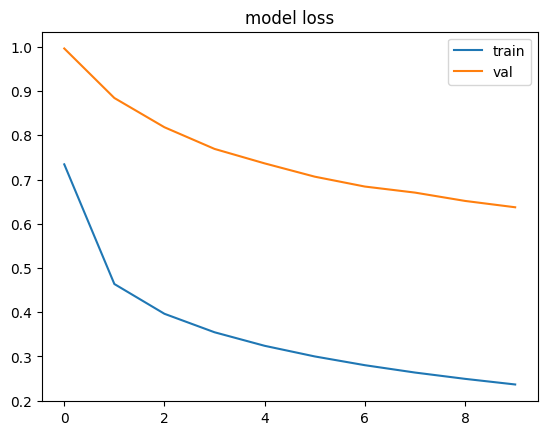

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train','val'])
plt.plot()

[]

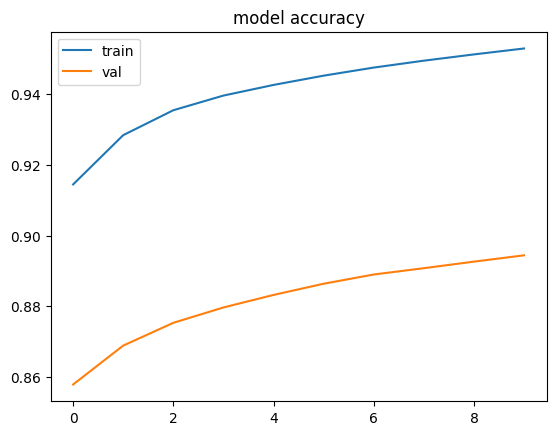

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train','val'])
plt.plot()

# Testing

In [ ]:
index_to_word={x:y for x, y in zip(range(len(french_vector_layer.get_vocabulary())),
                                   french_vector_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence=english_vector_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vector_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('it is very good day')

1/1 [==============================] - 0s 23ms/step


'cest très bon grand que la vie'

## With BLEU score metrics

In [27]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [28]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),
    metrics=[BLEU()],
    run_eagerly=True)

In [29]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    )

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
   2754/Unknown - 9129s 3s/step - loss: 0.4755 - bleu: 0.4043

KeyboardInterrupt: 

In [30]:
seq2seq_gru.evaluate(val_dataset)

    160/Unknown - 840s 5s/step - loss: 0.5110 - bleu: 0.3824

KeyboardInterrupt: 